# Quality of information
The main purpose of this exercise is to check a hypothesis that exponentially increasing number of published scientific articles is leading to an overall decrease  of their quality. AS part of this a calculation of retraction rates could be used. Another potential measure could be a replication score - how many of the articles have been replicated or, more interestingly, have failed to be replicated.

## Background and existing research:
- http://retractiondatabase.org - a nice database containing retracted article data. Database is available for research purposes, but for public access there is a limit of 50 results per search query and 100 searches per month so dificult to collect the data. Scraping will likely not work as well, as parts of the data require specified queries to get the full results. 3 data sets are available:
    - total retraction counts since 1960 (probably no point to look at the data prior to 1990)
    - retracted articles for time period 1960-1994 (needs extensive cleanup to be fully utilised)
    - Retracted articles in 2020 (Also needs cleanup)
- https://www.science.org/content/article/what-massive-database-retracted-papers-reveals-about-science-publishing-s-death-penalty - a nice article based on the database above - could be methodological basis for the myth check but only properly explores the data up to 2015 - would be nice to add data up to 2020 and see has the trend changed or not.
- https://www.pnas.org/doi/10.1073/pnas.1212247109 - Also a nice methodology from 2012. Probably no time for replication but maybe something to have in mind.
- https://link.springer.com/article/10.1007/s11192-021-03987-y - One more interesting resource, not necessarily relevant.
- https://link.springer.com/article/10.1007/s11192-018-2922-4 - One more solid looking article.
- https://royalsocietypublishing.org/doi/10.1098/rsos.200566 - An article on replication rates.

## Thing still to be done
- Better data cleanup to better categorise reasons of retractions.
- Try to find number of articles published for each of the jornals mentioned in the retraction database to have a better measure than simply absolute retraction counts.
- Figure out how to get data for the rest of the years - maybe it's worth focusing on specific area or country (probably something other than US - UK or France or Germany perhaps)

In [1]:
library(data.table)
library(ggplot2)
suppressPackageStartupMessages(library(lubridate))

## Total Retractions
Restrict to 1990 - 2021 as majority of retractions seem to be done within 2 years from publication and data before 1990 seems unreliable

In [2]:
getwd()

[1] "D:/Work/SD - Mitas/Informacijos kokybe"

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 32 rows containing missing values (geom_point)."
Warning message:
"Removed 32 row(s) containing missing values (geom_path)."


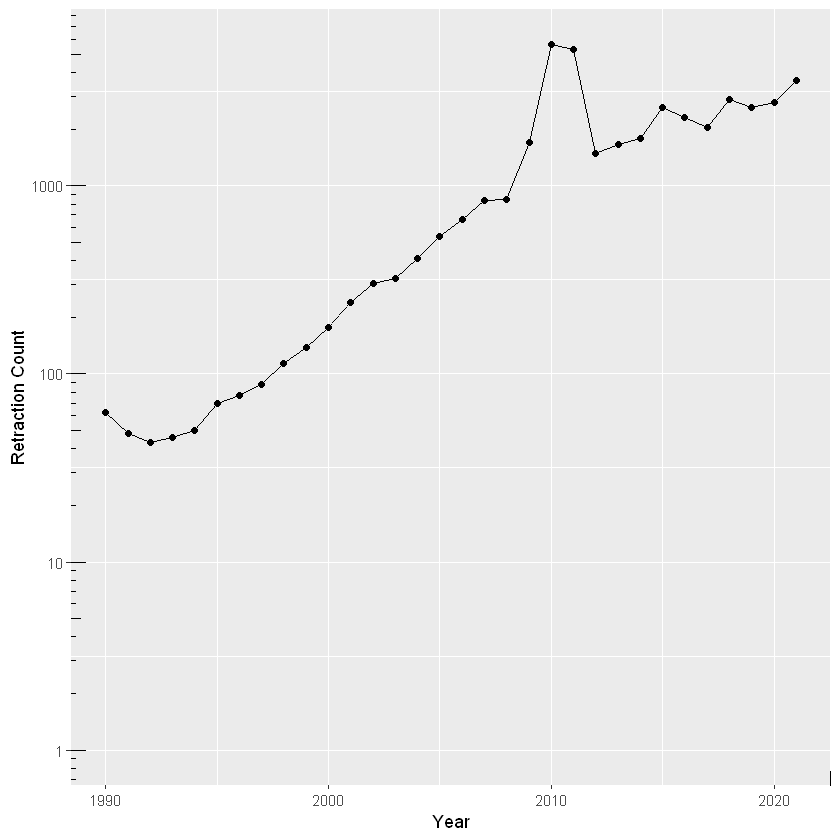

In [3]:
dt_in_tt <- fread("dt_in/retraction_counts.csv")

p_tt <- 
    ggplot(data = dt_in_tt, aes(x = Year, y = `Retraction Count`)) +
    geom_point() + 
    geom_line() +
    scale_x_continuous(limits = c(1990, 2021)) +
    scale_y_log10() +
    annotation_logticks()
p_tt

## Retraction split by time since publication
Calculate retraction counts since publication. For now using 4 date ranges:
- 0 - 1 year
- 2 - 3 years
- 4 - 5 years
- 6 - 10 years
- 11+ years
Alternative splits could be used - this should be investigated.

Even though retraction count is increasing time between article publication and retraction seems to be decreasing - better peer review? increased attention to quality of papers?

Warning message:
"Removed 153 rows containing missing values (position_stack)."
Warning message:
"Removed 5 rows containing missing values (geom_bar)."
Warning message:
"Removed 128 row(s) containing missing values (geom_path)."
Warning message:
"Removed 128 rows containing missing values (geom_point)."


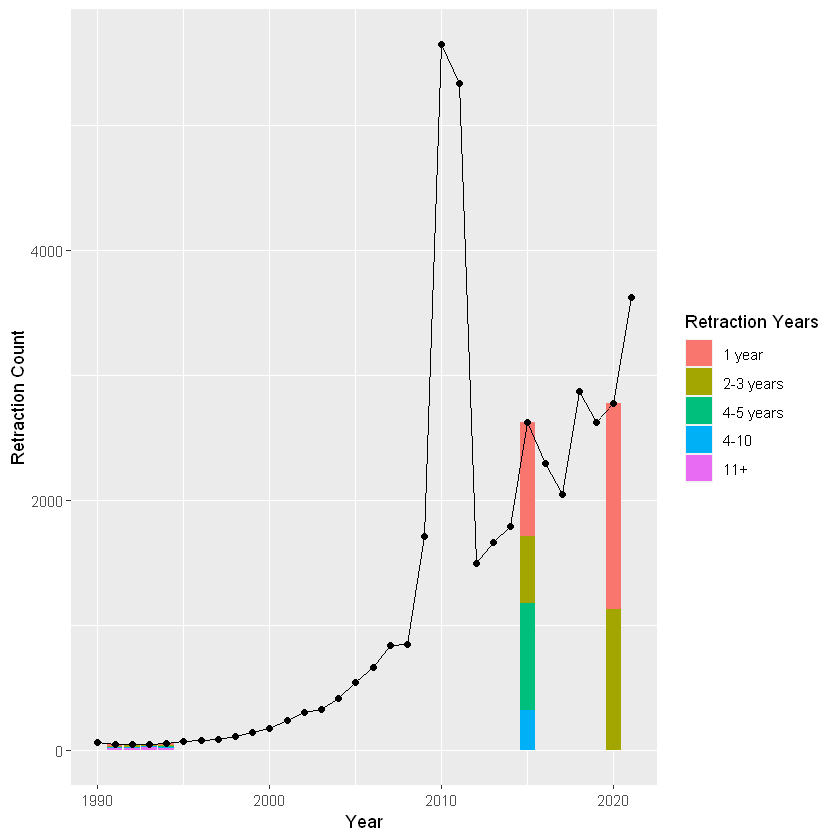

In [4]:
dt_in <- list()
dt_in[[1]] <- fread("dt_in/retractions_1960-1994.csv", header = FALSE)
dt_in[[2]] <- fread("dt_in/retractions_2015.csv", header = FALSE)
dt_in[[3]] <- fread("dt_in/retractions_2020.csv", header = FALSE)

dt_pr <-
    rbindlist(dt_in) |>
    setnames(old = paste0('V', 1:7), new = c("title", "reason", "author", "date_publish", "date_retract", "type", "countries"))
dt_pr <- copy(dt_pr[!grepl("reason\\(s\\)", reason, ignore.case = TRUE), ])

dt_pr[, c("dt_pub", "dt_ret") := list(mdy(stringi::stri_extract(date_publish, regex = "(?<!\\d)\\d{2}/\\d{2}/\\d{4}(?!\\d)")),
                                      mdy(stringi::stri_extract(date_retract, regex = "(?<!\\d)\\d{2}/\\d{2}/\\d{4}(?!\\d)")))]
dt_pr[, "ret_years" := year(dt_ret) - year(dt_pub)]

smr_year <- dt_pr[, .(`1 year`    = sum(ret_years <= 1),
                      `2-3 years` = sum(between(ret_years, 2,  3)),
                      `4-5 years` = sum(between(ret_years, 4,  5)),
                      `4-10`      = sum(between(ret_years, 6, 10)),
                      `11+`       = sum(ret_years > 10)), by = year(dt_pub)] |>
    melt(id.vars = "year", variable.name = "Retraction Years", value.name = "Retraction Count")

p_year_split <-
    dt_in_tt |>
    copy() |>
    setnames(old = "Retraction Count", new = "Total Retraction Count") |>
    merge(smr_year, by.x = "Year", by.y = "year", all.x = TRUE) |>
    ggplot() +
    scale_x_continuous(limits = c(1990, 2021)) +
    geom_bar(aes(x = Year, y = `Retraction Count`, fill = `Retraction Years`), stat = "identity") +
    geom_line(aes(x = Year, y = `Total Retraction Count`)) +
    geom_point(aes(x = Year, y = `Total Retraction Count`))
p_year_split

## Reasons of retraction
For now partition data into two discrete parts - papers retracted due to fraudulent reasons and papers retracted due to other reasons. Fraudulent retractions can be interpreted as ones where vbad quality paper has been published on purpose. Such articles are clasified as having one of the following keywords in reason for retraction:
- falsification
- fake
- paper mill
- plagiarism
While retraction count due to other reasons seem to remain stable retractions due to the fraudulent reasons seems to be driving the increase in retraction counts

[1] ""                                                        
  [2] "Concerns/Issues About Data"                              
  [3] "Investigation by Company/Institution"                    
  [4] "Misconduct by Company/Institution"                       
  [5] "Misconduct by Third Party"                               
  [6] "Upgrade/Update of Prior Notice"                          
  [7] "Ethical Violations by Author"                            
  [8] "Falsification/Fabrication of Data"                       
  [9] "Misconduct - Official Investigation/Finding"             
 [10] "Misconduct by Author"                                    
 [11] "Investigation by Third Party"                            
 [12] "Date of Retraction/Other Unknown"                        
 [13] "Plagiarism of Article"                                   
 [14] "Lack of IRB/IACUC Approval"                              
 [15] "Duplication of Article"                                  
 [16] "Author Unresponsive"                                     
 [17] "Manipulation of Images"                                  
 [18] "Objections by Author"                                    
 [19] "Results Not Reproducible"                                
 [20] "Unreliable Results"                                      
 [21] "Investigation by Journal/Publisher"                      
 [22] "Unreliable Data"                                         
 [23] "Duplicate Publication through Error by Journal/Publisher"
 [24] "Criminal Proceedings"                                    
 [25] "Investigation by ORI"                                    
 [26] "Error in Data"                                           
 [27] "Error in Materials"                                      
 [28] "Error in Results and/or Conclusions"                     
 [29] "Error in Analyses"                                       
 [30] "Notice - Limited or No Information"                      
 [31] "Notice - Lack of"                                        
 [32] "Notice - Unable to Access via current resources"         
 [33] "Error in Image"                                          
 [34] "Concerns/Issues About Results"                           
 [35] "Error in Methods"                                        
 [36] "Falsification/Fabrication of Results"                    
 [37] "Concerns/Issues about Referencing/Attributions"          
 [38] "Retract and Replace"                                     
 [39] "Breach of Policy by Author"                              
 [40] "Duplication of Image"                                    
 [41] "Copyright Claims"                                        
 [42] "Withdrawal"                                              
 [43] "Plagiarism of Data"                                      
 [44] "Euphemisms for Duplication"                              
 [45] "Contamination of Cell Lines/Tissues"                     
 [46] "Falsification/Fabrication of Image"                      
 [47] "Unreliable Image"                                        
 [48] "Transfer of Copyright/Ownership"                         
 [49] "Bias Issues or Lack of Balance"                          
 [50] "Lack of Approval from Author"                            
 [51] "Concerns/Issues About Authorship"                        
 [52] "Plagiarism of Text"                                      
 [53] "Civil Proceedings"                                       
 [54] "Lack of Approval from Company/Institution"               
 [55] "Contamination of Materials"                              
 [56] "Error by Third Party"                                    
 [57] "Manipulation of Results"                                 
 [58] "Conflict of Interest"                                    
 [59] "Concerns/Issues About Image"                             
 [60] "False/Forged Authorship"                                 
 [61] "Sabotage of Materials"                                   
 [62] "Error in Text"                

Warning message:
"Removed 81 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."
Warning message:
"Removed 56 row(s) containing missing values (geom_path)."
Warning message:
"Removed 56 rows containing missing values (geom_point)."


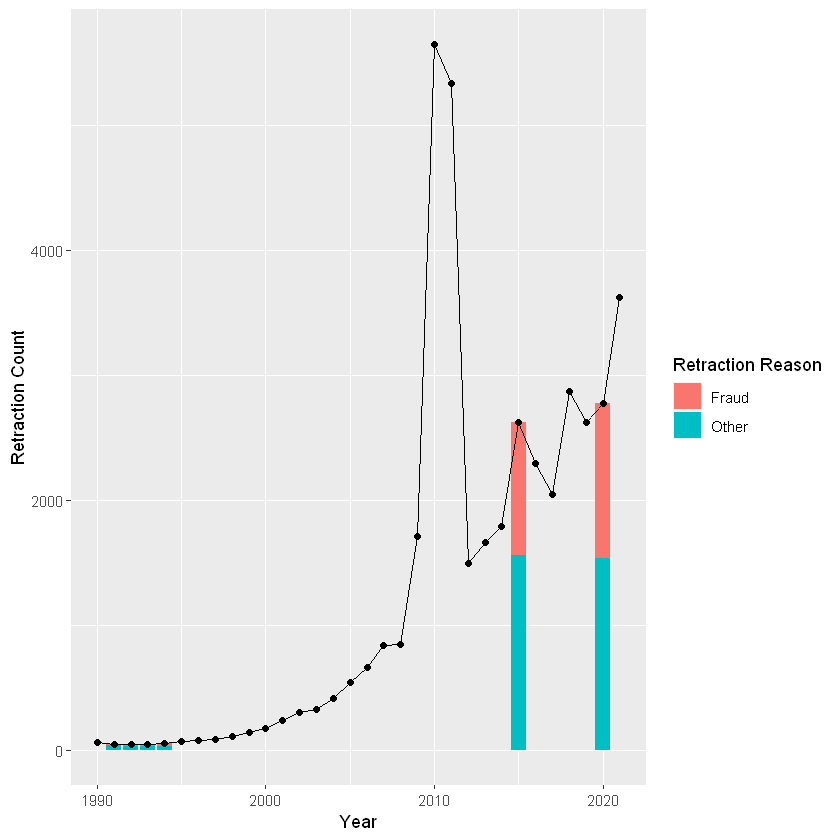

In [5]:
# Reasons of retraction
dt_pr[["reason"]] |> strsplit("+", fixed = TRUE) |> unlist() |> unique()
dt_pr[, "is_fraud"  := grepl("falsification|fake|paper mill|plagiarism", reason, perl = TRUE, ignore.case = TRUE)]

smr_fraud <- dt_pr[, .(Fraud       = sum(is_fraud),
                       Other       = sum(!is_fraud)), by = year(dt_pub)] |>
    melt(id.vars = "year", variable.name = "Retraction Reason", value.name = "Retraction Count")

p_reason_split <-
    dt_in_tt |>
    copy() |>
    setnames(old = "Retraction Count", new = "Total Retraction Count") |>
    merge(smr_fraud, by.x = "Year", by.y = "year", all.x = TRUE) |>
    ggplot() +
    scale_x_continuous(limits = c(1990, 2021)) +
    geom_bar(aes(x = Year, y = `Retraction Count`, fill = `Retraction Reason`), stat = "identity") +
    geom_line(aes(x = Year, y = `Total Retraction Count`)) +
    geom_point(aes(x = Year, y = `Total Retraction Count`))
p_reason_split